# Google Stock Price Classification
- This model uses a feed forward neural network that predicts the closing prices of the google stock using the variables of year, month, day, opening price, and volume

## Model Architecture
- Total layers = 4
- input layer with 5 variables: year, month, day, opening price, and volume
- hidden layer sizes: 32
- Class size: 1
- activation function: ReLU
- loss function: MSELoss
- optimizer: Adam
- Epochs: 2
- batch size: 10
- learning rate: 0.0001

## Model Evaluation
- Metric: R2 Score

## Dataset info
- Dataset is from kaggle and dates from 14.06.2016-11.06.2021
- Number of rows (Samples) in our dataset is 1208

## Result
- The model performs lackingly in terms of predicting the stock price of Google. This conclusion is from R2 score being extremely low around 0.1-0.3
- - With some modifications the Score increases, however, with the specified hyper parameters above, the R2 score is this.
- Reason for this might be the small size of the dataset, and also the model architechture itself might not be suitable.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# IMPORTING DATA AND PREPROCESSING IT
data = pd.read_csv("../datasets/GOOG.csv")
data["date"] = pd.to_datetime(data["date"])
data["Year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data.drop(columns = ["date"])


,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,Year,month,day
0,GOOG,718.27,722.470,713.1200,716.48,1306065,718.27,722.470,713.1200,716.48,1306065,0.0,1.0,2016,6,14
1,GOOG,718.92,722.980,717.3100,719.00,1214517,718.92,722.980,717.3100,719.00,1214517,0.0,1.0,2016,6,15
2,GOOG,710.36,716.650,703.2600,714.91,1982471,710.36,716.650,703.2600,714.91,1982471,0.0,1.0,2016,6,16
3,GOOG,691.72,708.820,688.4515,708.65,3402357,691.72,708.820,688.4515,708.65,3402357,0.0,1.0,2016,6,17
4,GOOG,693.71,702.480,693.4100,698.77,2082538,693.71,702.480,693.4100,698.77,2082538,0.0,1.0,2016,6,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,GOOG,2466.09,2468.000,2441.0725,2451.32,1192453,2466.09,2468.000,2441.0725,2451.32,1192453,0.0,1.0,2021,6,7
1254,GOOG,2482.85,2494.495,2468.2400,2479.90,1253253,2482.85,2494.495,2468.2400,2479.90,1253253,0.0,1.0,2021,6,8
1255,GOOG,2491.40,2505.000,2487.3300,2499.50,1006337,2491.40,2505.000,2487.3300,2499.50,1006337,0.0,1.0,2021,6,9
1256,GOOG,2521.60,2523.260,2494.0000,2494.01,1561733,2521.60,2523.260,2494.0000,2494.01,1561733,0.0,1.0,2021,6,10


In [4]:
scaler = StandardScaler()

features = data.loc[:, ["Year","month", "day", "open", "volume"]]
labels = data.loc[:, "close"]
features = scaler.fit_transform(np.asarray(features))
labels = scaler.fit_transform(np.asarray(labels).reshape(-1,1))

features = torch.tensor(features).type(torch.float32)
labels = torch.tensor(labels).type(torch.float32)

xtrain, xtest, ytrain, ytest = train_test_split(features,labels, train_size=0.8)

In [5]:
# DEFINING HYPERPARAMETERS
epochs = 5
batchsize = 25
learning_rate = 0.0001
inputsz = features.shape[1]
hid1 = 32
hid2 = 32
outsz = labels.shape[1]


In [6]:
# Creating the custom dataset class
class Google_stock_db(Dataset):
    def __init__(self, features, labels):
        self.feats = features
        self.labels = labels

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        inputs = self.feats[idx].to(device)
        label = self.labels[idx].to(device)
        return inputs, label

In [7]:
# Creating the model architechture
class FFGoogleStockClassification(nn.Module):
    def __init__(self, inputsz, hid1sz, hid2sz, outsz, activation=nn.ReLU()):
        super(FFGoogleStockClassification, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(inputsz, hid1sz),
            activation,
            nn.Linear(hid1sz, hid2sz),
            activation,
            nn.Linear(hid2sz, outsz)
        )

    def forward(self, x):
        output = self.sequential(x)
        return output

In [8]:
# Creating our dataloaders and initializing the model, loss function, and optimizer
traindb = Google_stock_db(xtrain,ytrain)
testdb = Google_stock_db(xtest, ytest)

trainloader = DataLoader(traindb, batch_size=batchsize, shuffle=False)
testloader = DataLoader(testdb, batch_size=batchsize, shuffle=False)

model = FFGoogleStockClassification(inputsz, hid1, hid2, outsz).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [9]:
# Training the model
model.train()
loss = 0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        
        output = model(inputs)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

print(f"loss: {loss}")

loss: 0.16161005198955536


In [10]:
# Evaluating the model
model.eval()
# Initializing the metrics
R2metric = torchmetrics.R2Score().to(device)

# Variables for plotting the testing
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in testloader:
        output = model(inputs)
        
        predictions.extend(output.cpu().numpy())
        actuals.extend(labels.cpu().numpy())
        R2metric.update(output,labels)

R2Score = R2metric.compute()

print(f"R2 Score: {R2Score}")

R2 Score: 0.4386623501777649


In [11]:
# inverse scaling the predictions and labels
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)


In [12]:
# comparing a random index
import random
random = random.randrange(0, len(actuals))
print(f"single prediction: {predictions[random]}\nActual value: {actuals[random]}\nIndex: {random}")

single prediction: [1295.22862784]
Actual value: [1417.02000143]
Index: 174


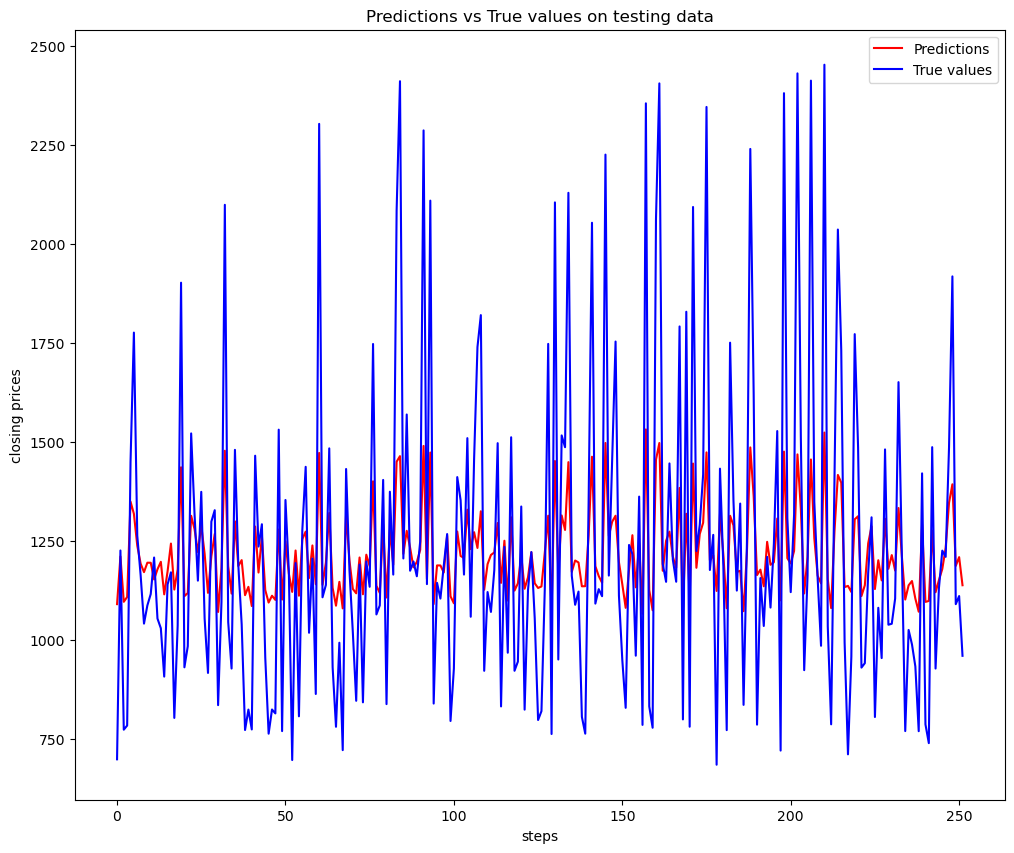

In [13]:
# Plotting the results
plt.figure(figsize=(12,10))
plt.plot(predictions, label="Predictions", color="Red")
plt.plot(actuals, label="True values", color="Blue")
plt.title("Predictions vs True values on testing data")
plt.xlabel("steps")
plt.ylabel("closing prices")
plt.legend()
plt.show()